<function matplotlib.pyplot.show(close=None, block=None)>

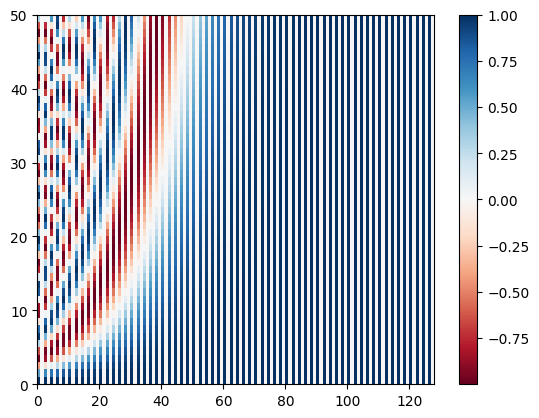

In [1]:
import math
import torch
from torch import nn
from matplotlib import  pyplot as plt

class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len,dropout=0.1):
        super().__init__()
        self.dropout=nn.Dropout(p=dropout)
        
        position=torch.arange(max_len).unsqueeze(1)
        div_term=torch.exp(
            torch.arange(0,d_model,2)*(-math.log(10000.0)/d_model)
        )
        pe=torch.zeros(max_len,1,d_model)
        pe[:,0,0::2]=torch.sin(position*div_term)
        pe[:,0,0::2]=torch.cos(position*div_term)
        self.register_buffer("pe",pe)
        
    def forward(self,x):
        x=x+self.pe[: x.size(0)]
        return self.dropout(x)
    
encoding=PositionalEncoding(d_model=128,max_len=50)

plt.pcolormesh(encoding.pe.numpy().squeeze(),cmap="RdBu")
plt.xlim((0,128))
plt.colorbar()
plt.show

Transformer Model


In [3]:
import math
import torch
from torch import nn

class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len,dropout=0.1):
        super().__init__()
        self.dropout=nn.Dropout(p=dropout)
        
        position=torch.arange(max_len).unsqueeze
        div_ter=torch.exp(
            torch.arange(0,d_model,2)*(-math.log(10000.0)/d_model)
        )
        
        pe=torch.zeros(max_len,1,d_model)
        pe[:,0,0::2]=torch.sin(position*div_ter)
        pe[:,0,1::2]=torch.cos(position*div_ter)
    
    def forward(self,x):
        x=x+self.pe[: x.size(0)]
        return self.dropout(x)
    
class TokenEmbedding(nn.Module):
    def __init__(self,vocab_size,emb_size):
        super().__init()
        self.embedding=nn.Embedding(vocab_size)
        self.emb_size=emb_size
        
    def forward(self,tokens):
        return self.embedding(tokens.long())*math.sqrt(self.emb_size)
    
class Seq2SeqTransformer(nn.Module):
    def __init__(
        self,
        num_encoder_layers,
        num_decoder_layers,
        emb_size,
        max_len,
        nhead,
        src_vocab_size,
        tgt_vocab_size,
        dim_feedforward,
        dropout=0.1,
    ):
        super().__init__()
        self.src_tok_emb=TokenEmbedding(src_vocab_size,emb_size)
        self.tgt_tok_emb=TokenEmbedding(tgt_vocab_size,emb_size)
        self.positional_encoding=PositionalEncoding(
            d_model=emb_size,max_len=max_len,dropout=dropout
        )
        self.transformer=nn.Transformer(
            d_model=emb_size,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            
        )
        self.generator=nn.Linear(emb_size,tgt_vocab_size)
        
    def forward(
        self,
        src,
        trg,
        src_mask,
        tgt_mask,
        src_padding_mask,
        tgt_padding_mask,
        memory_key_padding_mask,
    ):
        src_emb=self.positional_encoding(self.src_tok_emb(src))
        tgt_emb=self.positional_encoding(self.tgt_tok_emb(trg))
        outs=self.transformer(
            src=src_emb,
            tgt=tgt_emb,
            src_maks=src_mask,
            tgt_mask=tgt_mask,
            memory_mask=None,
            src_key_padding_mask=src_padding_mask,
            tgt_key_padding_mask=tgt_padding_mask,
            memory_key_padding_mask=memory_key_padding_mask
        )
        return self.generator(outs)
    
    def encode(self,src,src_mask):
        return self.transformer.encoder(
            self.positional_encoding(self,src_tok_emb(src)),src_mask
        )
        
    def decode(self,tgt,tgt_mask):
        return self.transformer.decoder(
            self.positional_encoding(self,tgt_tok_emb(tgt)),tgt_mask
        )
        

임베딩 차원 (d_model) : 트랜스포머 모델의 입출력 차원의 크기 정의

헤드 (nhead) : 멀티 헤드 어텐션의 헤드 개수 정의. 헤드의 개수는 모델이 어텐션을 수행하는 방법 결정, 헤드의 개수가 많을수록 모델의 병렬 처리 능력 증가. but, 헤드의 개수 증가할수록 매개변수 수 증가

인코더 계층 개수 (num_encoder_layers) & 디코더 계층 개수 (num_decoder_layers) : 인코더와 디코더의 계층 수 의미. 모델의 복잡도와 성능에 영향. 계층 많을수록 더 복잡한 문제 해결 , 너무 많으면 과대적합

순방향 신경망 크기 (dim_feedforward) : 순방향 신경망의 은닉층 크기. 순방향 신경망 계층은 트랜스포머 계층의 각 입력 위치에 독집적으로 적용

드롭아웃 (dropout) : 인코더와 디코더 계층에 적용되는 드롭아웃 비율

계층 정규화 입실론 (layer_norm_eps) : 계층 정규화를 수행할 때 분모에 더해지는 입실론 값

In [6]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

model_id="meta-llama/Llama-3.2-3B-Instruct"  
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# EOS토큰을 PAD토큰으로 지정하여 warning이 나오지 않게 함 warnings
model = AutoModelForCausalLM.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)
input_ids = tokenizer.encode('I enjoy walking with my cute dog', return_tensors='pt')

/home/kkwon/.local/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/kkwon/.local/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this 

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [8]:
beam_output = model.generate(
    input_ids, 
    max_length=50, 
    num_beams=5, 
    no_repeat_ngram_size=2, # 2-gram의 어구가 반복되지 않도록 설정함
    early_stopping=True
)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(beam_output[0], skip_special_tokens=True))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Output:
----------------------------------------------------------------------------------------------------
I enjoy walking with my cute dog, but I'm not sure if I'll ever be able to walk with him again.

I've been thinking about this for a while now, and I think it's time for me to take a break
